# H1C IDR3.2 Triad Redundancy

In [1]:
import os
import h5py
import numpy as np
from itertools import product

import sys
sys.path.append("/users/pkeller/code/H1C_IDR3.2/")

from closurelib import cptools as cp
from closurelib import plot

from ipywidgets import interact

import matplotlib.pyplot as plt

## Load Data

In [2]:
# data directory
ddir = "/lustre/aoc/projects/hera/pkeller/data/H1C_IDR3.2/sample/"

# triad names
trnames = ["EQ14", "EQ28"]

# field names
fnames = ["A", "B", "C", "D", "E"]

# polarisations
polnames = ["XX", "YY"]

data = dict()

for trname, fname, polname in product(trnames, fnames, polnames):
    name = f"{trname}_F{fname}"
    dname = name + f"_{polname}"
    path = os.path.join(ddir, f"{name}_B2.h5")
    data.update({dname: dict()})
        
    with h5py.File(path, "r") as f:
        data[dname].update({"triads": f[f"triads {polname}"][()]})
        data[dname].update({"eicp": f[f"eicp jdmed (2) {polname}"][()].mean(0)})

flags = dict()

## Compute Metric

In [3]:
for trname, fname, polname in product(trnames, fnames, polnames):
    dname = f"{trname}_F{fname}_{polname}"
    eicp = data[dname]["eicp"]
    meicp = np.median(eicp, axis=0)
    deicp = np.abs(np.angle(eicp[np.newaxis]*eicp[:, np.newaxis].conjugate()))
    deicp = deicp / np.nanmedian(deicp, axis=(0, 1))
    metric = np.nanmean(deicp, axis=(-1, -2))
    data[dname].update({"metric": metric})

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


In [4]:
eq14 = []
eq28 = []

for fname, polname in product(fnames, polnames):
    dname = f"_F{fname}_{polname}"
    eq14.extend(data["EQ14" + dname]["triads"].tolist())
    eq28.extend(data["EQ28" + dname]["triads"].tolist())
    
# unique list of triads
eq14 = np.unique(eq14, axis=0)
eq28 = np.unique(eq28, axis=0)

## Average Metrics

In [5]:
metric_eq14_list = {"XX": [], "YY": []}
metric_eq28_list = {"XX": [], "YY": []}

for fname, polname in product(fnames, polnames):
    dname = f"_F{fname}_{polname}"
    
    metric_eq14 = np.zeros(2 * (len(eq14),))
    metric_eq28 = np.zeros(2 * (len(eq28),))
    
    eq14_idx = np.array([(tr == eq14).all(-1) for tr in data["EQ14" + dname]["triads"]])
    eq28_idx = np.array([(tr == eq28).all(-1) for tr in data["EQ28" + dname]["triads"]])
    eq14_idx = np.where(eq14_idx)[1]
    eq28_idx = np.where(eq28_idx)[1]
    
    metric_eq14[np.ix_(eq14_idx, eq14_idx)] = data["EQ14" + dname]["metric"]
    metric_eq28[np.ix_(eq28_idx, eq28_idx)] = data["EQ28" + dname]["metric"]
    
    metric_eq14[np.where(metric_eq14 == 0)] = np.nan
    metric_eq28[np.where(metric_eq28 == 0)] = np.nan
    
    metric_eq14_list[polname].append(metric_eq14)
    metric_eq28_list[polname].append(metric_eq28)

In [6]:
metric_eq14_xx = np.nanmedian(metric_eq14_list["XX"], axis=0)
metric_eq28_xx = np.nanmedian(metric_eq28_list["XX"], axis=0)
metric_eq14_yy = np.nanmedian(metric_eq14_list["YY"], axis=0)
metric_eq28_yy = np.nanmedian(metric_eq28_list["YY"], axis=0)

trmetric_eq14_xx = np.nanmean(metric_eq14_xx, axis=1)
trmetric_eq28_xx = np.nanmean(metric_eq28_xx, axis=1)
trmetric_eq14_yy = np.nanmean(metric_eq14_yy, axis=1)
trmetric_eq28_yy = np.nanmean(metric_eq28_yy, axis=1)

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


## Plot

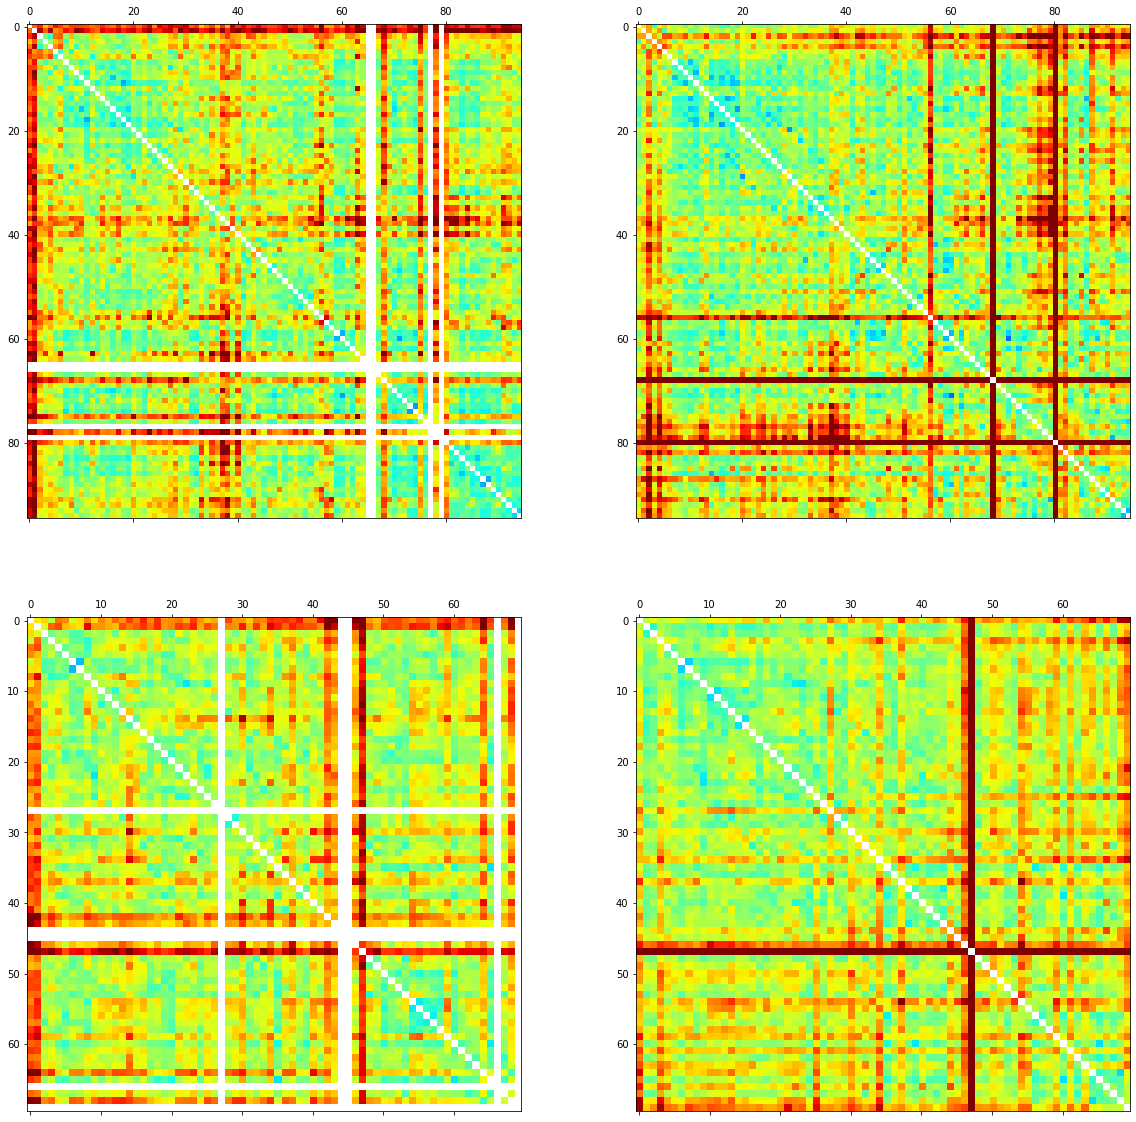

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax[0, 0].matshow(metric_eq14_xx.astype(float), vmin=0, vmax=2, cmap="jet")
ax[0, 1].matshow(metric_eq14_yy.astype(float), vmin=0, vmax=2, cmap="jet")
ax[1, 0].matshow(metric_eq28_xx.astype(float), vmin=0, vmax=2, cmap="jet")
ax[1, 1].matshow(metric_eq28_yy.astype(float), vmin=0, vmax=2, cmap="jet")

0.20680845235170964
0.9


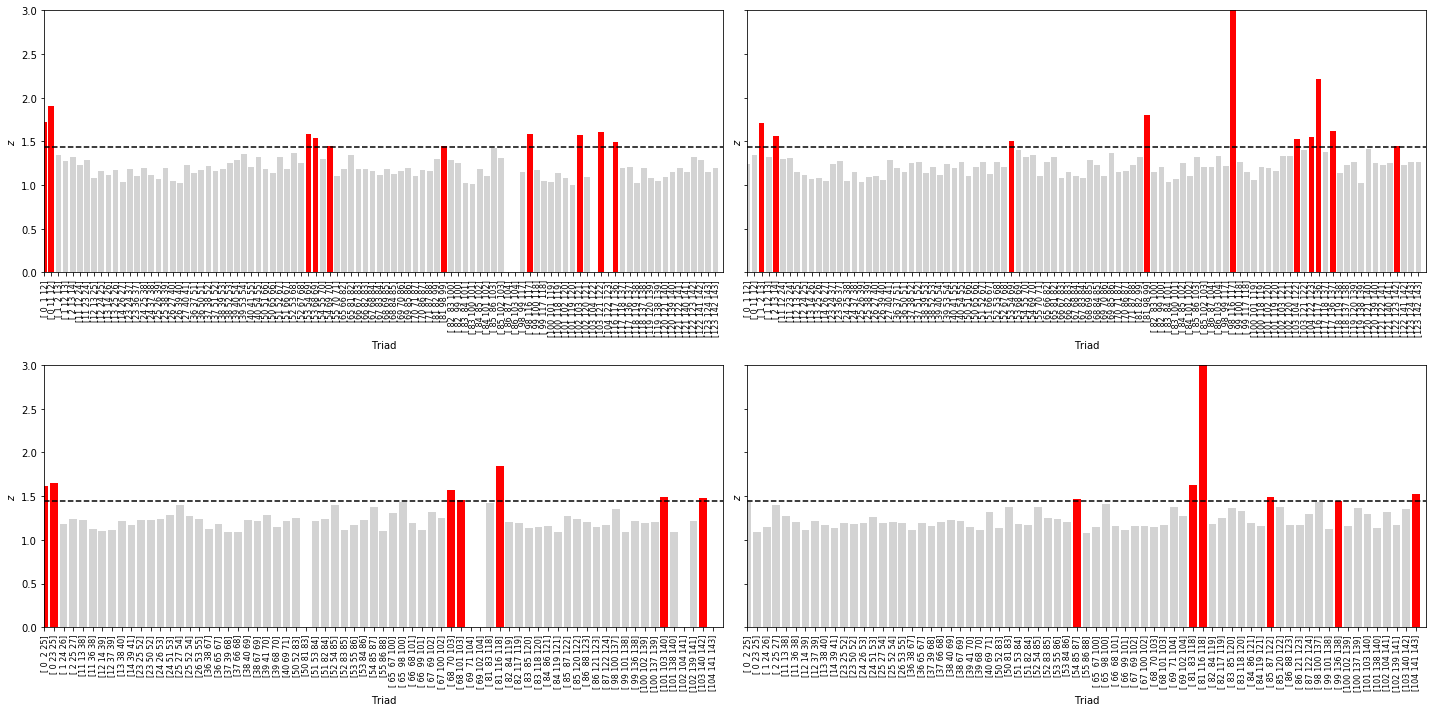

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10), sharey=True)
trmetrics = [trmetric_eq14_xx, trmetric_eq14_yy, trmetric_eq28_xx, trmetric_eq28_yy]
trlists = [eq14, eq14, eq28, eq28]
z = 1.44


for i, (trred, trlist) in enumerate(zip(trmetrics, trlists)):
    trflags = trred > z
    ax[i//2, i%2].bar(np.arange(len(trlist))[~trflags], trred[~trflags], color="lightgray", linewidth=0)
    ax[i//2, i%2].bar(np.arange(len(trlist))[trflags], trred[trflags], color="red", linewidth=0)
    ax[i//2, i%2].set_ylabel(r"$z$")
    ax[i//2, i%2].set_xticklabels(trlist, fontsize=8, rotation=90)
    ax[i//2, i%2].hlines(z, 0, len(trlist)+1, linestyle="dashed")

    plt.setp(ax[i//2, i%2], xlabel="Triad", xlim=[0, len(trlist)], ylim=[0, 3], xticks=np.arange(0, len(trlist), 1.0),)
plt.tight_layout()

trred = np.hstack(trmetrics)
trflags = trred > z
print(np.nanvar(trred[~trflags]) / np.nanvar(trred))
print(len(trred[~trflags]) / len(trred))

## Write Flags to File

In [9]:
trmetrics = {"EQ14": {"XX": trmetric_eq14_xx, "YY": trmetric_eq14_yy}, "EQ28": {"XX": trmetric_eq28_xx, "YY": trmetric_eq28_yy}}
trlists = {"EQ14": eq14, "EQ28": eq28}

for trname, fname, polname in product(trnames, fnames, polnames):
    trred = trmetrics[trname][polname]
    trflags = (trred > z) | np.isnan(trred)
    
    name = f"{trname}_F{fname}"
    dname = f"{trname}_F{fname}_{polname}"
    triads = data[dname]["triads"]
    trflags = trflags[[(tr == triads).all(-1).any() for tr in trlists[trname]]]
    path = os.path.join(ddir, f"{name}_B2.h5")
    
    f = h5py.File(path, "a")
    if f"triad flags {polname}" in f.keys():
        del f[f"triad flags {polname}"]

    
    f.create_dataset(f"triad flags {polname}", data=trflags.astype(bool))
    f.close()